# Play Visualization Notebook

### Import Libraries

In [1]:
%matplotlib widget

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

### Import Data

In [3]:
def merge_input_output(
    df_input: pd.DataFrame,
    df_output: pd.DataFrame,
    label_col: str = "label",
    meta_cols=None,
) -> pd.DataFrame:
    """
    Merge pre-throw (input) and post-throw (output) tracking data.

    - Matches on ['game_id', 'play_id', 'nfl_id'].
    - Shifts output frame_id so it continues from the last input frame
      for each (game_id, play_id, nfl_id).
    - Adds a label label column (e.g. 'input' or 'output').
    - Optionally merges metadata columns from input onto output rows.

    Parameters
    ----------
    df_input : pd.DataFrame
        Pre-throw tracking data.
    df_output : pd.DataFrame
        Post-throw tracking data (frame_id usually restarts at 1).
    label_col : str, default "label"
        Name of the column indicating whether a row is from input or output.
    meta_cols : list of str or None
        Columns from df_input to copy onto df_output.
        If None, we'll infer as "all columns except the obvious
        time/position columns".

    Returns
    -------
    pd.DataFrame
        Combined DataFrame with continuous frame_id and a label label.
    """
    key_cols = ["game_id", "play_id", "nfl_id"]

    df_in = df_input.copy()
    df_out = df_output.copy()

    df_in[label_col] = "input"
    df_out[label_col] = "output"

    # ---- 1. Compute per-player offset = last input frame ----
    offsets = (
        df_in.groupby(key_cols)["frame_id"]
        .max()
        .rename("frame_offset")
        .reset_index()
    )

    # Attach offsets to output; if no input exists, offset = 0
    df_out = df_out.merge(offsets, on=key_cols, how="left")
    df_out["frame_offset"] = df_out["frame_offset"].fillna(0).astype(int)

    # Shift output frame_id
    df_out["frame_id"] = df_out["frame_id"] + df_out["frame_offset"]
    df_out = df_out.drop(columns=["frame_offset"])

    # ---- 2. Bring metadata from input onto output rows (optional but useful) ----
    if meta_cols is None:
        # infer metadata cols = everything in input that's not clearly
        # temporal/position and not a key
        exclude = set(key_cols + ["frame_id", "x", "y", "s", "a", "dir", "o", label_col])
        meta_cols = [c for c in df_in.columns if c not in exclude]

    if meta_cols:
        meta_df = df_in[key_cols + meta_cols].drop_duplicates(subset=key_cols)
        df_out = df_out.merge(meta_df, on=key_cols, how="left")

    # ---- 3. Combine input + output ----
    df_all = pd.concat([df_in, df_out], ignore_index=True, sort=False)

    # Sort nicely
    df_all = df_all.sort_values(key_cols + ["frame_id"]).reset_index(drop=True)

    return df_all

In [4]:
input_path  = os.path.join(os.getcwd(), "data", "input_2023_w01.csv")
output_path = os.path.join(os.getcwd(), "data", "output_2023_w01.csv")

df_in  = pd.read_csv(input_path)
df_out = pd.read_csv(output_path)

df_merged = merge_input_output(df_in, df_out)
df_merged.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,label
0,2023090700,101,False,43290,1,right,42,Jared Goff,6-4,223,...,37.36,30.07,0.00,0.00,65.42,95.98,21,63.259998,-0.22,input
1,2023090700,101,False,43290,2,right,42,Jared Goff,6-4,223,...,37.36,30.07,0.00,0.00,63.91,95.98,21,63.259998,-0.22,input
2,2023090700,101,False,43290,3,right,42,Jared Goff,6-4,223,...,37.35,30.07,0.00,0.00,53.83,95.98,21,63.259998,-0.22,input
3,2023090700,101,False,43290,4,right,42,Jared Goff,6-4,223,...,37.34,30.07,0.00,0.00,310.79,95.98,21,63.259998,-0.22,input
4,2023090700,101,False,43290,5,right,42,Jared Goff,6-4,223,...,37.33,30.07,0.06,1.37,271.81,96.80,21,63.259998,-0.22,input


### Plot Play

In [5]:
def draw_nfl_field(ax=None):
    """
    Draw an NFL field in NGS coordinate system:
      x: 0–120, y: 0–53.3
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Field background
    field = patches.Rectangle((0, 0), 120, 53.3,
                              linewidth=0, facecolor="#3f995b")
    ax.add_patch(field)

    # End zones
    home_ez = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0, facecolor="#2f7f4a")
    visitor_ez = patches.Rectangle((110, 0), 10, 53.3,
                                   linewidth=0, facecolor="#2f7f4a")
    ax.add_patch(home_ez)
    ax.add_patch(visitor_ez)

    # Outer border
    ax.plot([0, 120], [0, 0], color="white")
    ax.plot([0, 120], [53.3, 53.3], color="white")
    ax.plot([0, 0], [0, 53.3], color="white")
    ax.plot([120, 120], [0, 53.3], color="white")

    # Yard lines every 5 yards
    for x in range(10, 111, 5):
        lw = 1 if x % 10 else 2
        ax.plot([x, x], [0, 53.3], color="white", linewidth=lw, alpha=0.7)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

In [6]:
def animate_play(df_all, game_id, play_id, label_col="label"):
    """
    Animate a single play from a merged input+output tracking DataFrame.

    - Ball landing is shown from the start.
    - After the last 'input' frame, any player who is not in the output
      stays at their last input position as a ghost point.

    Required columns in df_all:
      ['game_id','play_id','nfl_id','frame_id','x','y',
       'player_side','absolute_yardline_number',
       'ball_land_x','ball_land_y', label_col]
    """

    # ---- Filter to this play ----
    play_df = df_all[
        (df_all["game_id"] == game_id) &
        (df_all["play_id"] == play_id)
    ].copy()

    if play_df.empty:
        raise ValueError("No rows found for that (game_id, play_id)")

    # Sort nicely
    play_df = play_df.sort_values(["frame_id", "nfl_id"])
    frames = np.sort(play_df["frame_id"].unique())

    # ---- Find last input frame & baseline positions ----
    if label_col in play_df.columns:
        input_mask = play_df[label_col] == "input"
    else:
        input_mask = np.zeros(len(play_df), dtype=bool)

    if input_mask.any():
        last_input_frame = play_df.loc[input_mask, "frame_id"].max()
        baseline_df = play_df.loc[
            (play_df["frame_id"] == last_input_frame) & input_mask
        ].set_index("nfl_id")
    else:
        last_input_frame = None
        baseline_df = None

    # ---- Team colors ----
    side_vals = play_df["player_side"].dropna().unique().tolist()
    color_palette = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
    side_to_color = {
        side_vals[i]: color_palette[i % len(color_palette)]
        for i in range(len(side_vals))
    }

    def get_colors(series):
        return series.map(lambda s: side_to_color.get(s, "black")).values

    # For baseline (ghost) players
    if baseline_df is not None:
        baseline_colors = get_colors(baseline_df["player_side"])
        baseline_colors_series = (
            pd.Series(baseline_colors, index=baseline_df.index)
        )
    else:
        baseline_colors_series = None

    # ---- LOS and ball landing ----
    los_x = play_df["absolute_yardline_number"].dropna().iloc[0]
    ball_x = play_df["ball_land_x"].dropna().iloc[0]
    ball_y = play_df["ball_land_y"].dropna().iloc[0]

    # ---- Set up figure ----
    fig, ax = plt.subplots(figsize=(12, 6))
    draw_nfl_field(ax)
    ax.set_title(f"Game {game_id}, Play {play_id}")

    # Line of scrimmage
    los_line = ax.axvline(
        los_x, color="yellow", linewidth=3, alpha=0.9, label="Line of scrimmage"
    )

    # Ball landing marker (visible from the start now)
    ball_marker = ax.scatter(
        ball_x, ball_y,
        marker="*",
        s=200,
        edgecolor="black",
        facecolor="gold",
        label="Ball landing",
        visible=True,
    )

    # Initial frame
    f0 = frames[0]
    frame0 = play_df[play_df["frame_id"] == f0]
    colors0 = get_colors(frame0["player_side"])

    # Live players (those that actually exist at a frame)
    scat_live = ax.scatter(
        frame0["x"], frame0["y"],
        s=60,
        edgecolor="black",
        linewidth=0.5,
        c=colors0,
        zorder=3,
    )

    # Ghost players (baseline-only, frozen after last input)
    scat_ghost = ax.scatter(
        [], [],  # start empty
        s=40,
        edgecolor="none",
        alpha=0.4,      # faded look
        zorder=2,
    )

    # Info text: frame + label
    label0 = frame0[label_col].iloc[0] if label_col in frame0 else ""
    info_text = ax.text(
        2, 52,
        f"Frame: {f0}  |  Label: {label0}",
        color="white",
        fontsize=10,
        va="top",
        ha="left",
    )

    # Legend handles for teams
    for side_val in side_vals:
        ax.scatter(
            [], [], c=side_to_color[side_val],
            s=60, edgecolor="black", label=str(side_val)
        )
    ax.legend(loc="upper right")

    # ---- Animation update ----
    def update(i):
        f = frames[i]
        frame_i = play_df[play_df["frame_id"] == f]

        # Update live players
        scat_live.set_offsets(frame_i[["x", "y"]].to_numpy())
        scat_live.set_facecolors(get_colors(frame_i["player_side"]))

        # Update info text
        label_val = frame_i[label_col].iloc[0] if label_col in frame_i else ""
        info_text.set_text(f"Frame: {f}  |  Label: {label_val}")

        # Ghost logic: only after last input frame
        if baseline_df is not None and last_input_frame is not None and f > last_input_frame:
            current_ids = set(frame_i["nfl_id"].unique())
            baseline_ids = set(baseline_df.index)
            ghost_ids = sorted(list(baseline_ids - current_ids))
            if ghost_ids:
                ghost_pos = baseline_df.loc[ghost_ids, ["x", "y"]].to_numpy()
                scat_ghost.set_offsets(ghost_pos)

                if baseline_colors_series is not None:
                    ghost_cols = baseline_colors_series.loc[ghost_ids].values
                    scat_ghost.set_facecolors(ghost_cols)
            else:
                scat_ghost.set_offsets(np.empty((0, 2)))
        else:
            # No ghosts during input frames
            scat_ghost.set_offsets(np.empty((0, 2)))

        return scat_live, scat_ghost, info_text, los_line, ball_marker

    anim = FuncAnimation(
        fig,
        update,
        frames=len(frames),
        interval=100,  # ms between frames
        blit=True
    )

    plt.tight_layout()
    plt.show()

    return anim

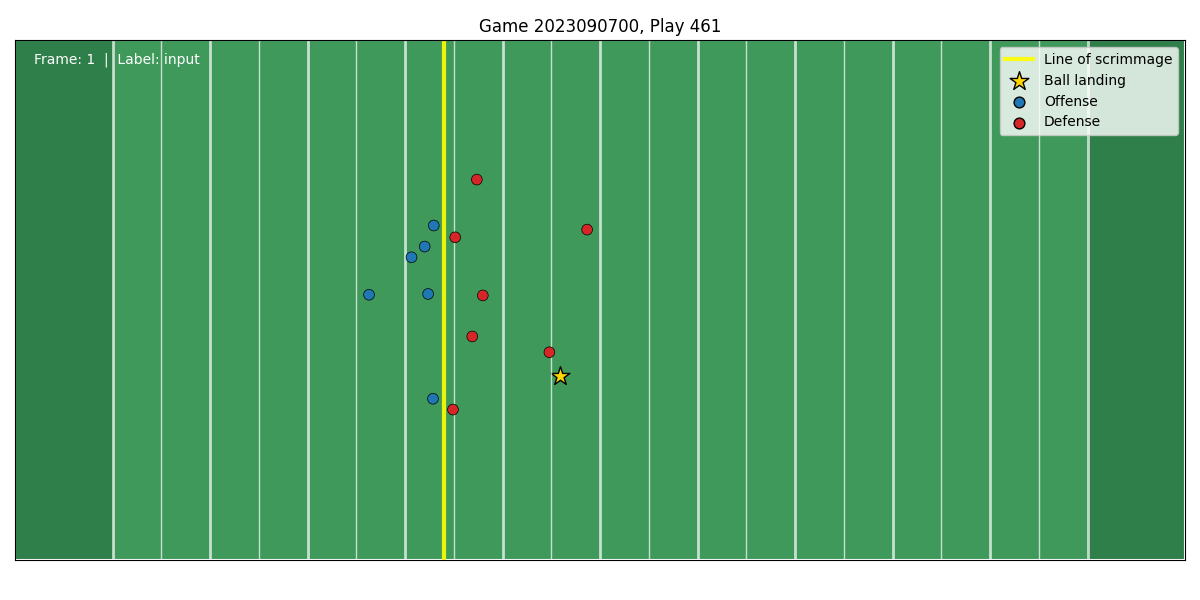

In [7]:
i = 2000

g_id = df_merged["game_id"].iloc[i]
p_id = df_merged["play_id"].iloc[i]

anim = animate_play(df_merged, game_id=g_id, play_id=p_id)